In [1]:
#making the correlation plot between evrery waveform

In [35]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose
import mplhep as hep

temp_stdout = None
# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout


PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100,2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
##########################################################################
threshold = 5 #threshold
bin_size = 11 #bin size aka time interval x0.625 ns
sample_size = 800 #the time interval for peak detection x0.625ns
E = 19 #energy
num =  1e4 #number of particles
detectordescription = "detector/ara2.json" #detector 
##########################################################################
#Nur path:
inputfilename1 = PATH + f"sims_monopoles_ara2_n1.000e04_3_18to20/Nur/1.000e{E}_3"
inputfilename2 = PATH + f"sims_neutrinos_ara2_n1.000e05_1_18to18/sim_1.000e{E}.nur"
inputfilename3 = PATH + f"sims_noise_ara2_n1.000e04_1_18to18/Nur/sim_1.000e18_part02.nur"
##########################################################################
#Hdf5 path:
path1 = PATH + f'sims_monopoles_ara2_n1.000e04_3_18to20/Hdf5/1.000e{E}'
path2 = PATH + f'sims_neutrinos_ara2_n1.000e05_1_18to18/sim_1.000e{E}.hdf5'
path3 = PATH + f'sims_noise_ara2_n1.000e04_1_18to18/Hdf5/'
#get_attr_data(path2)
##########################################################################
#Save data to csv file:
data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
data2 = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e03_1e{E}.csv'
data3 = PATH + f'Peak_data/Data_noise_ara2.csv'
##########################################################################
#Find peak and save data:
#save_data_2_csv(data1, inputfilename1, detectordescription, S_ID, C_ID)  
#save_data_2_csv(data2 ,inputfilename2, detectordescription, S_ID, C_ID)  
#save_data_2_csv(data3 ,inputfilename3, detectordescription, S_ID, C_ID)

In [36]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
channel_info = np.array([[100],[0]])

def get_trigger_event(data, s_ID, c_ID):
    data_frame = pd.read_csv(data)
    event_id = np.array(data_frame["event"])
    num_of_events = event_id[-1]
    e_id = list(range(1, int(event_id[-1]+1)))

    data = []
    event_id = []
    print("event_id", "number of data")
    for i in range(len(e_id)):
        trace_i = np.array(data_frame.query(f"station == {s_ID} and channel == {c_ID} and event == {i}")['Traces']) 
        if len(trace_i) == 0:
            pass
        else:
            print(i, len(trace_i))
            trace_i = list(trace_i)
            ##############################
            event_id.append(i)
            data.append(trace_i)
    return data
trace_neu =  get_trigger_event(data2, *channel_info)
trace_mm =  get_trigger_event(data1, *channel_info)


event_id number of data
1 1986
9 1734
10 1282
12 1582
18 1082
20 1884
event_id number of data
6 1362
40 1378
44 1350
72 1340


In [37]:
len(trace_neu), len(trace_mm)

(6, 4)

In [39]:
import radiotools.helper

def correlation(channel1, channel2):
    return radiotools.helper.get_normalized_xcorr(channel1,channel2)

#neurino to neutrino
pairs_correlation_n2n = [max(correlation(np.array(trace_neu[i]), np.array(trace_neu[j]))) for i in range(len(trace_neu))
         for j in range(i+1, len(trace_neu))]
#monopole to monopole
pairs_correlation_m2m = [max(correlation(np.array(trace_mm[i]), np.array(trace_mm[j]))) for i in range(len(trace_mm))
        for j in range(i+1, len(trace_mm))]
#monopole to neutrino
pairs_correlation_m2n = [max(correlation(np.array(trace_mm[i]), np.array(trace_neu[j]))) for i in range(len(trace_mm))
        for j in range(len(trace_neu))]


[0.08031051 0.12381929 0.16732807 0.21083685 0.25434563 0.2978544
 0.34136318 0.38487196 0.42838074 0.47188952 0.5153983  0.55890708
 0.60241585 0.64592463 0.68943341 0.73294219 0.77645097 0.81995975
 0.86346853 0.90697731 0.95048608]


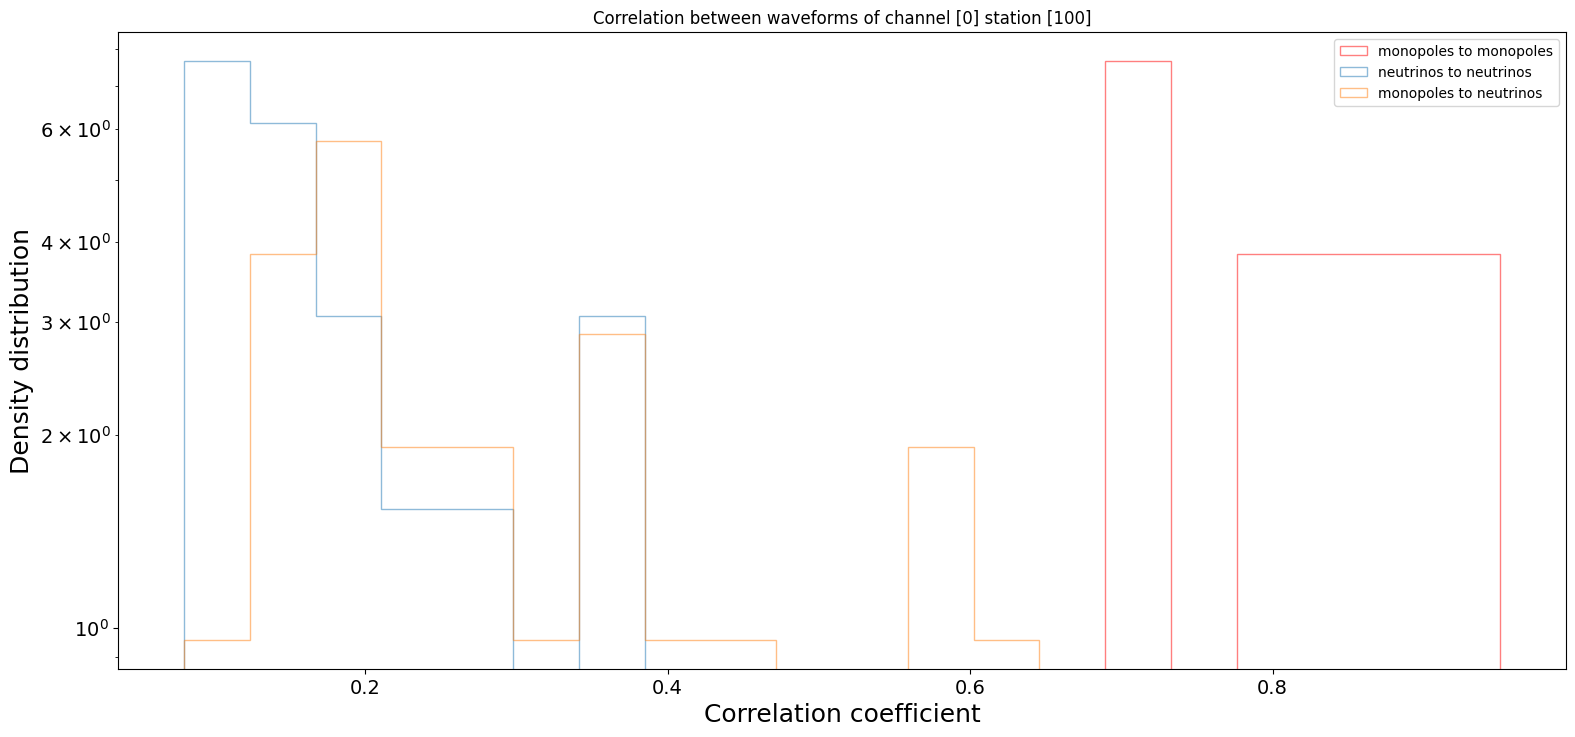

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Data for histograms
data1 = pairs_correlation_m2m
data2 = pairs_correlation_n2n
data3 = pairs_correlation_m2n
# Determine the common bin edges
bin_min = min(np.min(data1), np.min(data2))
bin_max = max(np.max(data1), np.max(data2))
num_bins = 20
bin_edges = np.linspace(bin_min, bin_max, num_bins + 1)
print(bin_edges)
# Create a figure and set up subplots
plt.figure( figsize=(15, 7))

# Plot the first histogram with log scale on y-axis
h1 = plt.hist(data1, bins=bin_edges , histtype='step', stacked=True, fill=False, color='red', alpha=0.5, label='monopoles to monopoles', density=True)

h2 = plt.hist(data2, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='neutrinos to neutrinos', density=True)

h3 = plt.hist(data3, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='monopoles to neutrinos', density=True)
# Add labels and title to the figure
plt.tight_layout()
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.yscale('log')
# Show the plot
plt.legend(loc='upper right')
plt.title(f'Correlation between waveforms of channel {channel_info[1]} station {channel_info[0]}')
plt.show()


Text(0.5, 1.0, 'Density distribution of correlation between waveforms of channel [0] station [100] at E = 19 EeV')

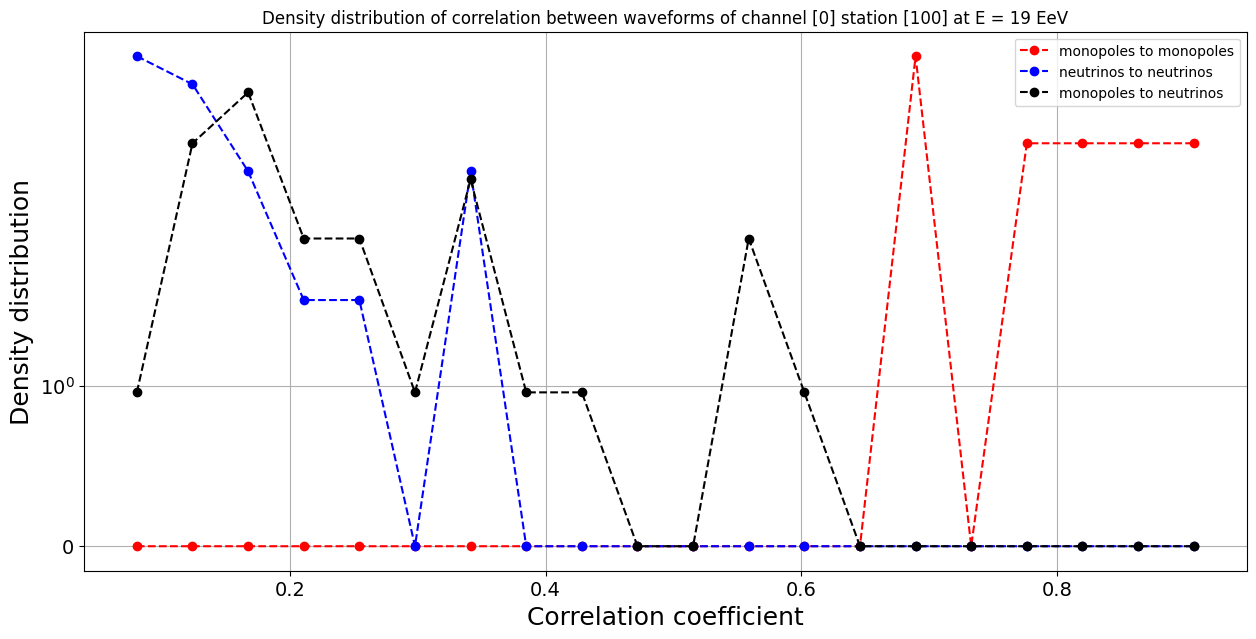

In [43]:
plt.figure(figsize=(15, 7))
plt.errorbar(h1[1][:-1], h1[0], fmt='--o', color='red', capsize=2, label='monopoles to monopoles')
plt.errorbar(h2[1][:-1], h2[0], fmt='--o', color='blue', capsize=2 , label='neutrinos to neutrinos')
plt.errorbar(h3[1][:-1], h3[0], fmt='--o', color='black', capsize=2 , label='monopoles to neutrinos')
plt.yscale('symlog')
#plt.xscale('log')
plt.grid()  
plt.legend(loc='upper right')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.title(f'Density distribution of correlation between waveforms of channel {channel_info[1]} station {channel_info[0]} at E = {E} EeV')


In [ ]:
for i in range(len(trace_neu)):
    for j in range(i+1, len(trace_neu)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_neu[j])))
        if corr >0.9:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_neu[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

(array([8.27844004, 2.48353201, 0.        , 1.65568801, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.07767491, 0.15820538, 0.23873585, 0.31926632, 0.39979679,
        0.48032726, 0.56085773, 0.6413882 , 0.72191867, 0.80244914,
        0.88297961]),
 [<matplotlib.patches.Polygon at 0x7f4d3da4b280>])

In [ ]:
for i in range(len(trace_neu)):
    for j in range(len(trace_mm)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_mm[j])))
        if corr >0.9:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_mm[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            